<a href="https://colab.research.google.com/github/Agil0509/Deep-Learning/blob/main/Signature_Matching_With_Siamese_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aqilismayilzade","key":"7ac7d6f00d69dcab292ddf7cade60098"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mallapraveen/signature-matching

Dataset URL: https://www.kaggle.com/datasets/mallapraveen/signature-matching
License(s): CC0-1.0


In [ ]:
!unzip '/content/signature-matching.zip'

Archive:  /content/signature-matching.zip
  inflating: custom/data.csv         
  inflating: custom/full/001/001_00.png  
  inflating: custom/full/001/001_01.png  
  inflating: custom/full/001/001_02.png  
  inflating: custom/full/001/001_03.png  
  inflating: custom/full/001/001_04.png  
  inflating: custom/full/001/001_05.png  
  inflating: custom/full/001/001_06.png  
  inflating: custom/full/001/001_07.png  
  inflating: custom/full/001/001_08.png  
  inflating: custom/full/001/001_09.png  
  inflating: custom/full/001/001_10.png  
  inflating: custom/full/001/001_11.png  
  inflating: custom/full/001/001_12.png  
  inflating: custom/full/001/001_13.png  
  inflating: custom/full/001/001_14.png  
  inflating: custom/full/001/001_15.png  
  inflating: custom/full/001/001_16.png  
  inflating: custom/full/001/001_17.png  
  inflating: custom/full/001/001_18.png  
  inflating: custom/full/001/001_19.png  
  inflating: custom/full/001/001_20.png  
  inflating: custom/full/001/001_21.pn

In [ ]:
import os

data_dir  = '/content/custom/full'

users = sorted([f for f in os.listdir(data_dir) if not f.endswith('_forg')])
len(users)

119

In [ ]:
import random
from glob import glob

def create_pairs(data_dir, users):
    pairs = []
    labels = []

    for user in users:
        gen_path = os.path.join(data_dir, user)
        forg_path = os.path.join(data_dir, f"{user}_forg")

        genuine_imgs = glob(f"{gen_path}/*.png")
        forged_imgs = glob(f"{forg_path}/*.png")

        # Positive pairs: Genuine-Genuine from same user
        for i in range(len(genuine_imgs)-1):
            pairs.append((genuine_imgs[i], genuine_imgs[i+1]))
            labels.append(1)

        # Negative pairs: Genuine-Forged
        for i in range(len(genuine_imgs)-1):
            if i+1< len(forged_imgs):
                pairs.append((genuine_imgs[i], forged_imgs[i+1]))
                labels.append(0)

    return pairs, labels


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def preprocess_image(path, target_size=(105, 105)):
    img = load_img(path, target_size=target_size, color_mode='grayscale')
    img = img_to_array(img) / 255.0
    return img

def create_dataset(pairs, labels):
    X1, X2 = [], []
    for img1_path, img2_path in pairs:
        X1.append(preprocess_image(img1_path))
        X2.append(preprocess_image(img2_path))

    return np.array(X1), np.array(X2), np.array(labels)


In [ ]:
from sklearn.model_selection import train_test_split

pairs, labels = create_pairs(data_dir, users)
X1, X2, y = create_dataset(pairs, labels)

X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(
    X1, X2, y, test_size=0.2, random_state=42
)

In [ ]:
y.sum()

np.int64(2088)

In [ ]:
len(y)-2088

1920

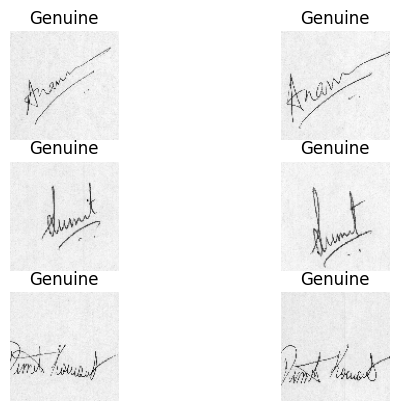

In [ ]:
import matplotlib.pyplot as plt


for i in range(3):
    num = np.random.randint(0,2088)
    plt.subplot(3,2,2*i+1)
    plt.title('Genuine')
    plt.imshow(X1[y==1][num],cmap = 'gray')
    plt.axis('off')
    plt.subplot(3,2,2*i+2)
    plt.imshow(X2[y==1][num],cmap = 'gray')
    plt.title('Genuine')
    plt.axis('off')



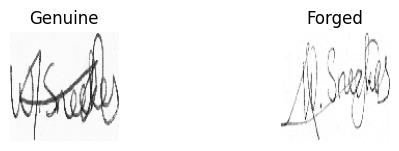

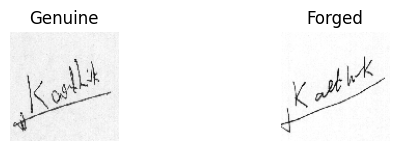

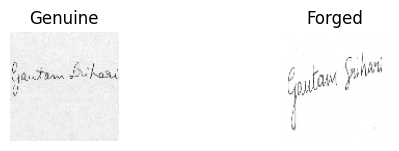

In [ ]:
for i in range(3):
    num = np.random.randint(0,1920)
    plt.subplot(3,2,2*i+1)
    plt.title('Genuine')
    plt.imshow(X1[y == 0][num],cmap = 'gray')
    plt.axis('off')
    plt.subplot(3,2,2*i+2)
    plt.title('Forged')
    plt.imshow(X2[y == 0][num],cmap = 'gray')
    plt.axis('off')
    plt.show()

In [ ]:
# import tensorflow as tf

# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip('horizontal'),
#     tf.keras.layers.RandomHeight(0.1),
#     tf.keras.layers.RandomRotation(0.1),
#     tf.keras.layers.RandomZoom(0.1),
#     tf.keras.layers.RandomWidth(0.1)
# ])

In [ ]:
import tensorflow as tf

def base_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape = input_shape),
        # data_augmentation,
        tf.keras.layers.Conv2D(64,3,activation = 'relu', padding = 'valid'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64)
    ])
    return model

In [ ]:
X1_train.shape

(3206, 105, 105, 1)

In [ ]:
from tensorflow.keras import backend as K

def cosine_similarity(vectors):
    x1,x2 = vectors

    x1 = K.l2_normalize(x1, axis = 1)
    x2 = K.l2_normalize(x2, axis = 1)
    return K.sum(x1 *x2, axis = 1, keepdims = True)

In [ ]:
def build_siamese_model(input_shape):
    base_network = base_model(input_shape)

    input_a = tf.keras.layers.Input(shape = input_shape)
    input_b = tf.keras.layers.Input(shape = input_shape)

    emb_a = base_network(input_a)
    emb_b = base_network(input_b)

    similarity = tf.keras.layers.Lambda(cosine_similarity)([emb_a,emb_b])
    output = tf.keras.layers.Activation('sigmoid')(similarity)

    siamese_model = tf.keras.models.Model(inputs = [input_a,input_b], outputs = [output])
    return siamese_model

In [ ]:
model = build_siamese_model(input_shape=(105,105,1))

model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

early_stoping = tf.keras.callbacks.EarlyStopping(patience=5, monitor = 'val_loss')

model.fit([X1_train,X2_train], y_train, epochs = 40,
          validation_data = ((X1_val,X2_val),y_val),
          callbacks = [early_stoping])

Epoch 1/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.5378 - loss: 0.7663 - val_accuracy: 0.6172 - val_loss: 0.6540
Epoch 2/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6505 - loss: 0.6318 - val_accuracy: 0.6808 - val_loss: 0.6098
Epoch 3/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7419 - loss: 0.5637 - val_accuracy: 0.7332 - val_loss: 0.5654
Epoch 4/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7971 - loss: 0.5214 - val_accuracy: 0.7781 - val_loss: 0.5322
Epoch 5/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8577 - loss: 0.4738 - val_accuracy: 0.8067 - val_loss: 0.5047
Epoch 6/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9119 - loss: 0.4302 - val_accuracy: 0.8130 - val_loss: 0.4916
Epoch 7/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9378 - loss: 0.3990 - val_accuracy: 0.8030 - val_loss: 0.5002
Epoch 8/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9570 - loss: 0.3824 - val_accu

In [ ]:
model.evaluate((X1_val, X2_val), y_val)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8590 - loss: 0.4542


[0.4461419880390167, 0.8740648627281189]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_prob = model.predict((X1_val, X2_val))

y_pred = []
for i in y_prob:
    if i>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print('Precision Score: ',precision_score(y_val,y_pred))
print('Recall Score: ', recall_score(y_val,y_pred))
print('F1 Score: ', f1_score(y_val,y_pred))

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Precision Score:  0.8344226579520697
Recall Score:  0.9387254901960784
F1 Score:  0.8835063437139562
